# 384x384 Crop 검증
512x512 -> 384x384 crop이 정상적으로 되었는지 확인하고,
기존 관측소 좌표가 384x384 이미지에 올바르게 매핑되는지 검증

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from utils.projection import (
    ASOS_LAND_COORD, 
    ASOS_COAST_COORD, 
    coord_to_map, 
    get_crop_base
)

In [2]:
# 경로 설정
SRC_DIR = Path("D:/data/date_kst_URP")        # 원본 512x512
DST_DIR = Path("D:/data/date_kst_URP_384")    # Crop된 384x384

# Crop 설정 (512x512 -> 384x384)
CROP_SIZE = 384
CROP_START_Y = 64  # 상단에서 64픽셀
CROP_START_X = 64  # 좌측에서 64픽셀

# 기존 512x512 기준 설정
ORIGIN_SIZE_512 = 900  # 2km 해상도
IMAGE_SIZE_512 = 512

## 1. 데이터 Shape 검증

In [3]:
# 샘플 파일 확인
date_folders = sorted([d for d in DST_DIR.iterdir() if d.is_dir()])
print(f"총 날짜 폴더 수: {len(date_folders)}")
print(f"첫 번째 폴더: {date_folders[0].name}")

# 첫 번째 파일 로드
sample_files = sorted(date_folders[0].glob("*.npy"))
print(f"첫 번째 폴더 내 파일 수: {len(sample_files)}")
print(f"샘플 파일: {sample_files[0].name}")

총 날짜 폴더 수: 1643
첫 번째 폴더: 20200101
첫 번째 폴더 내 파일 수: 8
샘플 파일: 16ch_202001010000.npy


In [4]:
# 원본과 crop 데이터 비교
sample_src_path = SRC_DIR / date_folders[0].name / sample_files[0].name
sample_dst_path = sample_files[0]

src_data = np.load(sample_src_path)
dst_data = np.load(sample_dst_path)

print(f"원본 (512x512) shape: {src_data.shape}")
print(f"Crop (384x384) shape: {dst_data.shape}")
print(f"\n예상 shape: (16, 384, 384)")
print(f"Shape 일치 여부: {dst_data.shape == (16, 384, 384)}")

원본 (512x512) shape: (16, 512, 512)
Crop (384x384) shape: (16, 384, 384)

예상 shape: (16, 384, 384)
Shape 일치 여부: True


In [5]:
# Crop 영역 값 일치 검증
src_cropped = src_data[:, CROP_START_Y:CROP_START_Y+CROP_SIZE, CROP_START_X:CROP_START_X+CROP_SIZE]

is_equal = np.allclose(src_cropped, dst_data)
print(f"Crop 영역 값 일치 여부: {is_equal}")

if not is_equal:
    diff = np.abs(src_cropped - dst_data)
    print(f"최대 차이: {diff.max()}")
    print(f"평균 차이: {diff.mean()}")

Crop 영역 값 일치 여부: True


## 2. 관측소 좌표 변환 (512 -> 384)

In [6]:
# 기존 512x512 기준 관측소 좌표 계산
asos_x_base, asos_y_base, asos_image_size = get_crop_base(IMAGE_SIZE_512, label_type='asos')
print(f"512x512 crop base: x={asos_x_base}, y={asos_y_base}, size={asos_image_size}")

# 512x512 기준 관측소 맵 좌표
asos_land_map_512 = {k: coord_to_map(*v, ORIGIN_SIZE_512) for k, v in ASOS_LAND_COORD.items()}
asos_land_map_512 = {k: (v[0] - asos_x_base, v[1] - asos_y_base) for k, v in asos_land_map_512.items()}

asos_coast_map_512 = {k: coord_to_map(*v, ORIGIN_SIZE_512) for k, v in ASOS_COAST_COORD.items()}
asos_coast_map_512 = {k: (v[0] - asos_x_base, v[1] - asos_y_base) for k, v in asos_coast_map_512.items()}

print(f"\n512x512 기준 관측소 좌표 (샘플):")
for i, (k, v) in enumerate(list(asos_land_map_512.items())[:3]):
    print(f"  {k}: {v}")

512x512 crop base: x=269, y=309, size=512

512x512 기준 관측소 좌표 (샘플):
  93: (255, 142)
  108: (221, 163)
  112: (207, 168)


In [7]:
# 384x384 기준으로 좌표 변환 (64픽셀 offset 적용)
asos_land_map_384 = {k: (v[0] - CROP_START_X, v[1] - CROP_START_Y) for k, v in asos_land_map_512.items()}
asos_coast_map_384 = {k: (v[0] - CROP_START_X, v[1] - CROP_START_Y) for k, v in asos_coast_map_512.items()}

print("384x384 기준 관측소 좌표:")
print("\n[육지 관측소 - ASOS Land]")
for k, v in asos_land_map_384.items():
    in_bounds = 0 <= v[0] < CROP_SIZE and 0 <= v[1] < CROP_SIZE
    status = "O" if in_bounds else "X (범위 밖)"
    print(f"  {k}: ({v[0]:3d}, {v[1]:3d}) - {status}")

print("\n[해안 관측소 - ASOS Coast]")
for k, v in asos_coast_map_384.items():
    in_bounds = 0 <= v[0] < CROP_SIZE and 0 <= v[1] < CROP_SIZE
    status = "O" if in_bounds else "X (범위 밖)"
    print(f"  {k}: ({v[0]:3d}, {v[1]:3d}) - {status}")

384x384 기준 관측소 좌표:

[육지 관측소 - ASOS Land]
  93: (191,  78) - O
  108: (157,  99) - O
  112: (143, 104) - O
  119: (158, 116) - O
  131: (179, 149) - O
  133: (176, 164) - O
  136: (234, 151) - O
  143: (233, 189) - O
  146: (165, 193) - O
  156: (156, 229) - O
  177: (146, 149) - O

[해안 관측소 - ASOS Coast]
  102: ( 61,  77) - O
  104: (238,  84) - O
  115: (327,  98) - O
  138: (265, 180) - O
  152: (264, 204) - O
  155: (231, 228) - O
  159: (251, 231) - O
  165: (133, 249) - O
  168: (194, 252) - O
  169: ( 91, 256) - O
  184: (140, 320) - O
  189: (142, 335) - O


In [8]:
# 범위 밖 관측소 확인
all_stations_384 = {**asos_land_map_384, **asos_coast_map_384}

in_bounds_count = 0
out_of_bounds = []

for k, (x, y) in all_stations_384.items():
    if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
        in_bounds_count += 1
    else:
        out_of_bounds.append((k, x, y))

print(f"총 관측소 수: {len(all_stations_384)}")
print(f"384x384 범위 내: {in_bounds_count}")
print(f"384x384 범위 밖: {len(out_of_bounds)}")

if out_of_bounds:
    print("\n범위 밖 관측소:")
    for k, x, y in out_of_bounds:
        print(f"  {k}: ({x}, {y})")

총 관측소 수: 23
384x384 범위 내: 23
384x384 범위 밖: 0


## 3. 시각화: 512x512 vs 384x384 비교

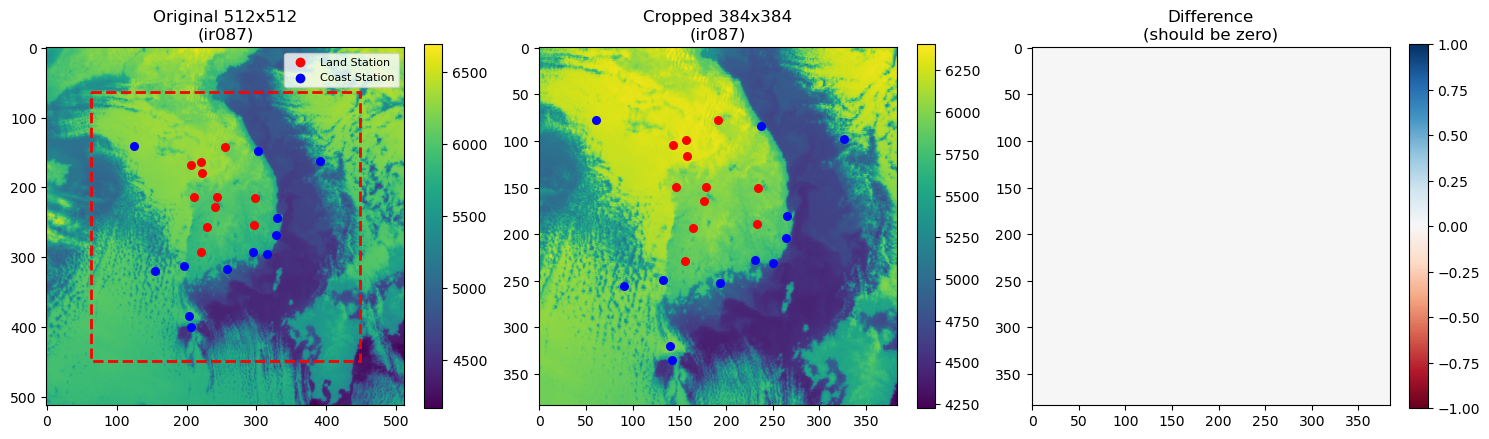

In [9]:
# 채널 하나 선택하여 비교 시각화
channel_idx = 10  # IR 채널 (ir087)
channel_names = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 512x512
ax1 = axes[0]
im1 = ax1.imshow(src_data[channel_idx], cmap='viridis')
ax1.set_title(f'Original 512x512\n({channel_names[channel_idx]})')
# Crop 영역 표시
rect = plt.Rectangle((CROP_START_X, CROP_START_Y), CROP_SIZE, CROP_SIZE, 
                       fill=False, edgecolor='red', linewidth=2, linestyle='--')
ax1.add_patch(rect)
# 512 기준 관측소 표시
for k, (x, y) in asos_land_map_512.items():
    ax1.scatter(x, y, c='red', marker='o', s=30)
for k, (x, y) in asos_coast_map_512.items():
    ax1.scatter(x, y, c='blue', marker='o', s=30)
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Crop된 384x384
ax2 = axes[1]
im2 = ax2.imshow(dst_data[channel_idx], cmap='viridis')
ax2.set_title(f'Cropped 384x384\n({channel_names[channel_idx]})')
# 384 기준 관측소 표시
for k, (x, y) in asos_land_map_384.items():
    if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
        ax2.scatter(x, y, c='red', marker='o', s=30)
for k, (x, y) in asos_coast_map_384.items():
    if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
        ax2.scatter(x, y, c='blue', marker='o', s=30)
plt.colorbar(im2, ax=ax2, fraction=0.046)

# 차이 (원본 crop 영역 vs crop된 데이터)
ax3 = axes[2]
diff = src_cropped[channel_idx] - dst_data[channel_idx]
im3 = ax3.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)
ax3.set_title(f'Difference\n(should be zero)')
plt.colorbar(im3, ax=ax3, fraction=0.046)

# 범례 추가
ax1.scatter([], [], c='red', marker='o', label='Land Station')
ax1.scatter([], [], c='blue', marker='o', label='Coast Station')
ax1.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## 4. 384x384에서 관측소 위치 상세 시각화

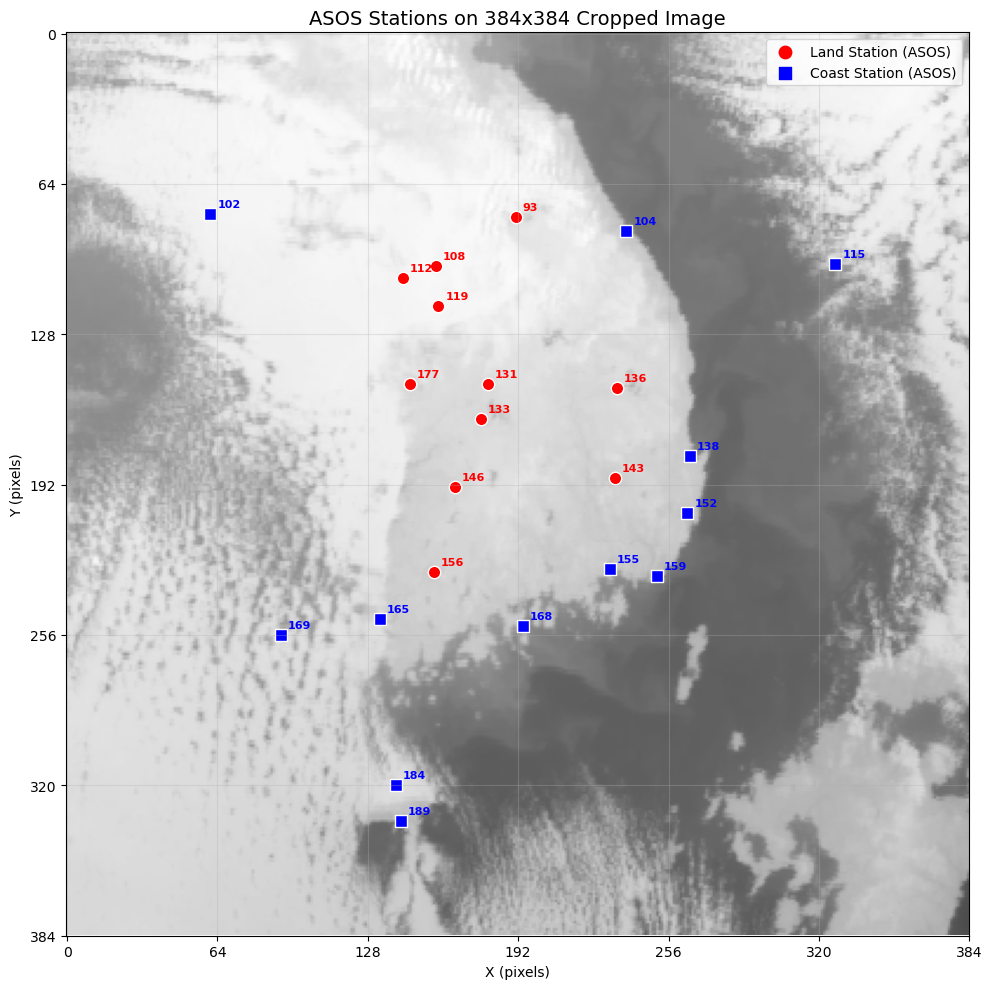

In [10]:
# 384x384 이미지에 관측소 위치 표시 (상세)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# IR 채널 배경
ax.imshow(dst_data[channel_idx], cmap='gray', alpha=0.7)

# 육지 관측소
for k, (x, y) in asos_land_map_384.items():
    if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
        ax.scatter(x, y, c='red', marker='o', s=80, edgecolors='white', linewidths=1)
        ax.annotate(str(k), (x, y), xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, color='red', fontweight='bold')

# 해안 관측소
for k, (x, y) in asos_coast_map_384.items():
    if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
        ax.scatter(x, y, c='blue', marker='s', s=80, edgecolors='white', linewidths=1)
        ax.annotate(str(k), (x, y), xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, color='blue', fontweight='bold')

# 범례
ax.scatter([], [], c='red', marker='o', s=80, label='Land Station (ASOS)')
ax.scatter([], [], c='blue', marker='s', s=80, label='Coast Station (ASOS)')
ax.legend(loc='upper right', fontsize=10)

ax.set_title('ASOS Stations on 384x384 Cropped Image', fontsize=14)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

# 그리드 표시
ax.set_xticks(np.arange(0, CROP_SIZE+1, 64))
ax.set_yticks(np.arange(0, CROP_SIZE+1, 64))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 여러 채널 확인

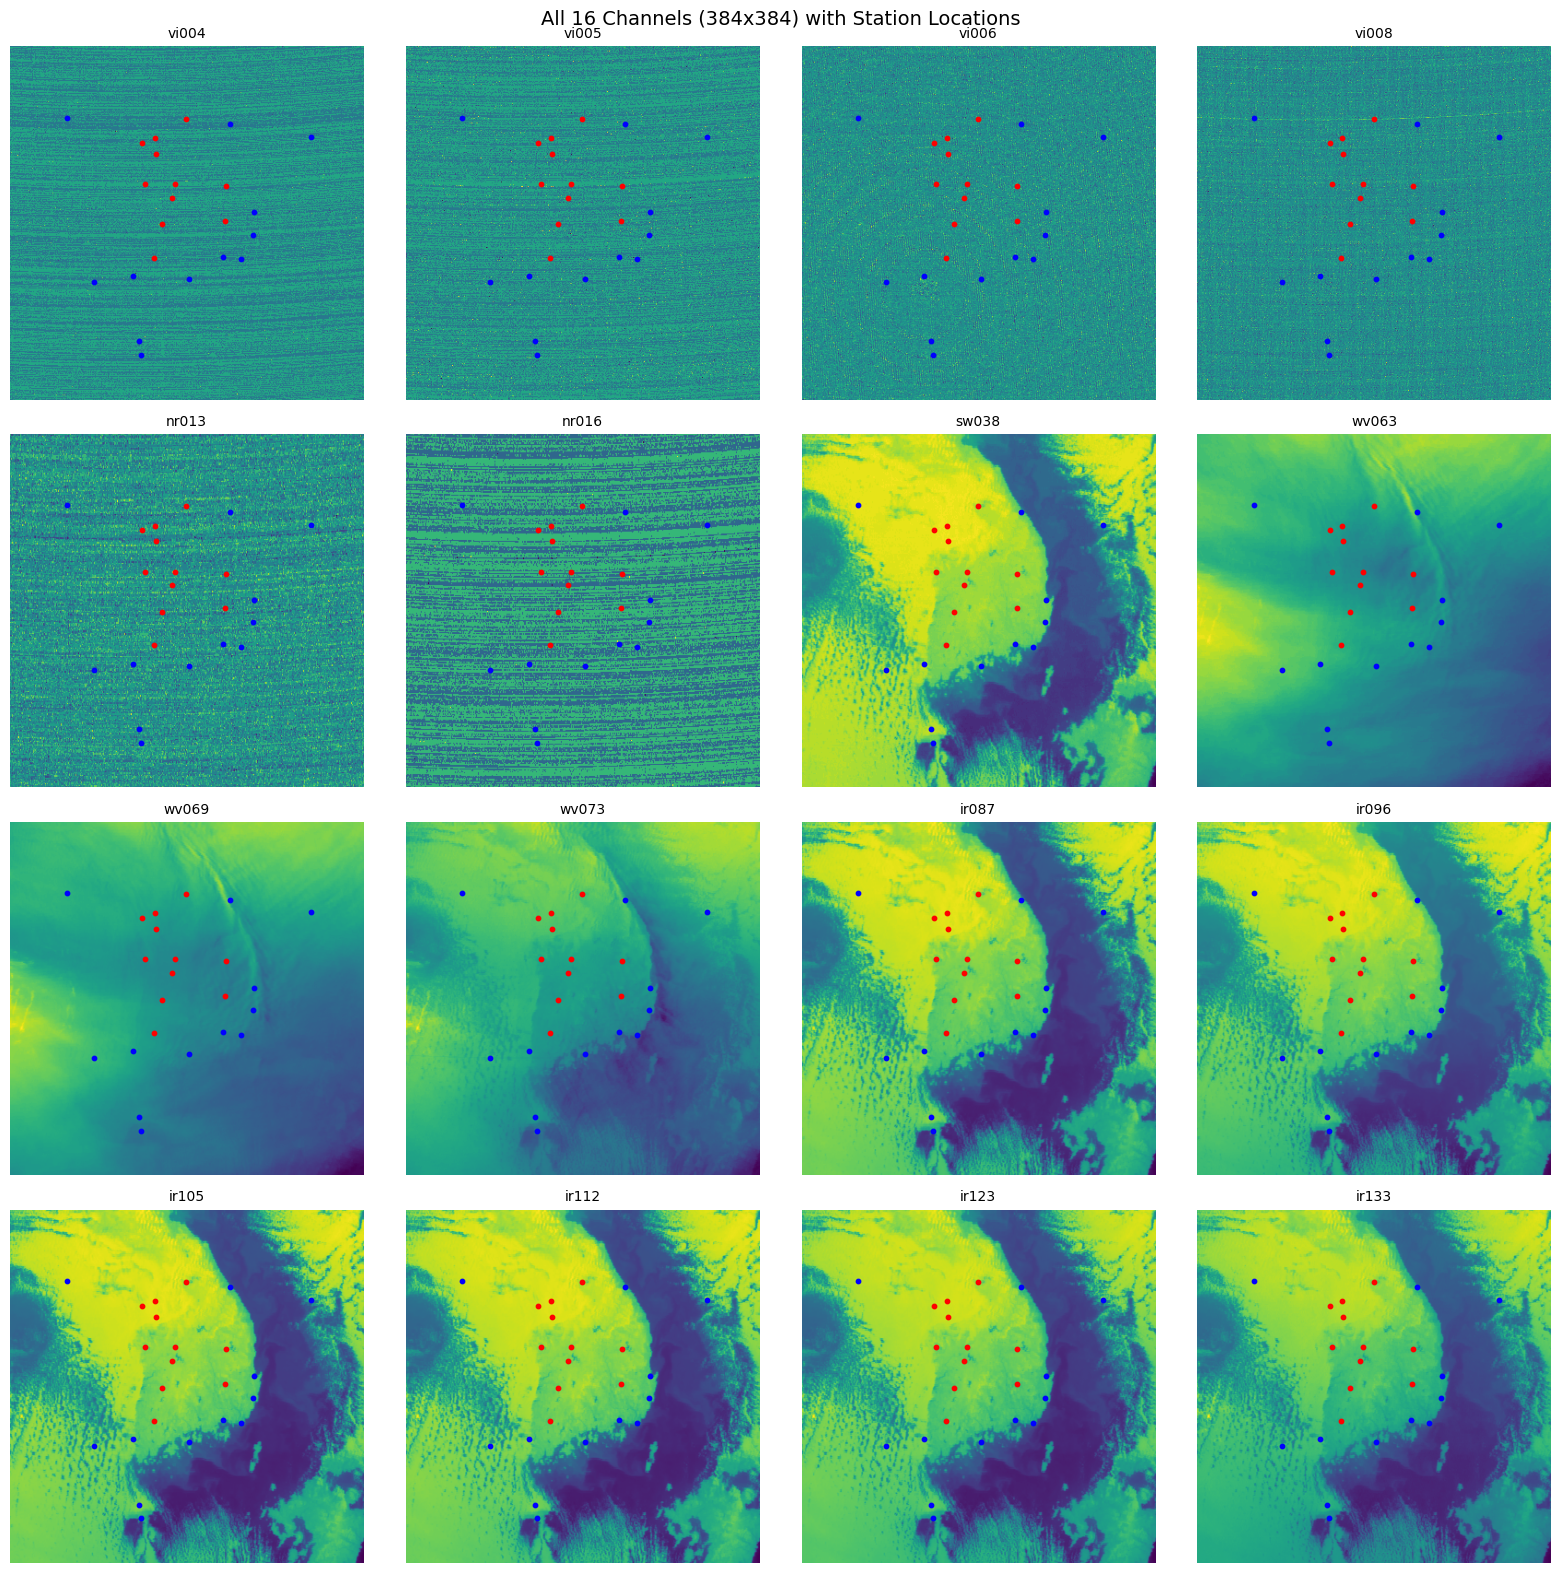

In [12]:
# 16개 채널 모두 표시
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(dst_data[i], cmap='viridis')
    ax.set_title(f'{channel_names[i]}', fontsize=10)
    
    # 관측소 위치 표시
    for k, (x, y) in asos_land_map_384.items():
        if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
            ax.scatter(x, y, c='red', marker='o', s=10)
    for k, (x, y) in asos_coast_map_384.items():
        if 0 <= x < CROP_SIZE and 0 <= y < CROP_SIZE:
            ax.scatter(x, y, c='blue', marker='o', s=10)
    
    ax.axis('off')

plt.suptitle('All 16 Channels (384x384) with Station Locations', fontsize=14)
plt.tight_layout()
plt.show()

## 6. 요약

In [13]:
print("=" * 60)
print("384x384 Crop 검증 결과 요약")
print("=" * 60)

print(f"\n[데이터 Shape]")
print(f"  원본: {src_data.shape}")
print(f"  Crop: {dst_data.shape}")
print(f"  Shape 정상: {dst_data.shape == (16, 384, 384)}")

print(f"\n[Crop 영역]")
print(f"  Y: {CROP_START_Y} ~ {CROP_START_Y + CROP_SIZE} (64 ~ 448)")
print(f"  X: {CROP_START_X} ~ {CROP_START_X + CROP_SIZE} (64 ~ 448)")
print(f"  값 일치: {np.allclose(src_cropped, dst_data)}")

print(f"\n[관측소 좌표 변환]")
print(f"  512 -> 384 offset: ({CROP_START_X}, {CROP_START_Y})")
print(f"  총 관측소: {len(all_stations_384)}개")
print(f"  384 범위 내: {in_bounds_count}개")
print(f"  384 범위 밖: {len(out_of_bounds)}개")

if len(out_of_bounds) > 0:
    print(f"\n[주의] 범위 밖 관측소가 있습니다:")
    for k, x, y in out_of_bounds:
        print(f"    {k}: ({x}, {y})")
else:
    print(f"\n[성공] 모든 관측소가 384x384 범위 내에 있습니다.")

print("\n" + "=" * 60)

384x384 Crop 검증 결과 요약

[데이터 Shape]
  원본: (16, 512, 512)
  Crop: (16, 384, 384)
  Shape 정상: True

[Crop 영역]
  Y: 64 ~ 448 (64 ~ 448)
  X: 64 ~ 448 (64 ~ 448)
  값 일치: True

[관측소 좌표 변환]
  512 -> 384 offset: (64, 64)
  총 관측소: 23개
  384 범위 내: 23개
  384 범위 밖: 0개

[성공] 모든 관측소가 384x384 범위 내에 있습니다.

